# Task 2 of the second CS985 project

## Introduction
The objective of the second task is to build a Neural Network model for image classification of CIFAR-10 data set. Two model types are to be implemented: Convolutional Neural Network (CNN) and Vision Transformer (ViT). 

CNNs are not a new approach in Machine Learning field, as its early works can be tracked to the end of last century. One such work of significant importance is (LeCun et al., 1989) [1] which used CNNs for classification of handwritten digits received by the US post office. However, the approach has not gain significant traction until 2012 and the work of (Krizhevsky et al., 2012) [2] which used a deep CNN for ImageNet challenge [3], which at the time, was a benchmark for image classification models. This work had significantly outperformed the previous state-of-the-art models and has caused a shift it in the approach for image processing tasks. In the following years after 2012 most of the entries to the said challenge have utilised CNNs. Some of the more popular works to come out of these submissions are: (Simonyan & Zisserman, 2015) [4] and (He et al., 2015) [5]. 

Compared to CNNs, ViTs are fairly new approach in image processing and were first introduced in 2021 by (Dosovitskiy et al., 2021) [6]. The approach is based on Transformers which are often used for Natural Language Processing (NLP) tasks. 

CNNs are based on applying filters (kernels) locally and computing their dot products, while ViT consider image globally. Both approaches are used here on CIFAR-10 data set. The data set contains 10 classes of images which are RGB and 32 by 32 pixels. The data set provides both the training and testing data and will require minimum pre-processing.

## Methodology

The entirety of this work is implemented locally without any use of cloud computing. The decision to use local hardware was based on RTX 4070 GPU being available. This GPU is significantly faster than T4 GPU given in the free tier of Google Colab and has allowed for more models to be trained with different sets of hyperparameters in the allocated time frame. To implement the code locally, Anaconda environment was first set up with Python 3.12.3. This was followed by obtaining the required packages (listed in the following section) and installing CUDA for managing GPU resources.

Once the initial set-up was completed, the notebook was organised into four parts. In the first part required libraries are loaded, data is obtained and pre-processed, and Validation, EarlyStop and Training functions are defined. These had to be defined manually as Neural Network (NN) training was conducted using PyTorch framework, which requires more costume implementation than some other NN frameworks, such as TensorFlow.

In the second part of the report three different CNN architectures are constructed. The first two architectures have two convolution layers and differ from one another by how deep these layers are. In the third CNN an additional convolution layer is added. The work refrained from adding further convolution layers due to small resolution of input images (32 by 32). The three defined CNNs are trained in four different settings:
* no augmentation and no interpolation
* no augmentation with interpolation
* augmentation without interpolation
* augmentation and interpolation

Each initially CNN training is conducted on truncated training data and evaluated on validation data. The best performing CNN model is then retrained on the whole training data (which includes the validation set) and is evaluated on the test data. By training the models in such a way, the work ensures that the final model does not overfit to the training data. Once the three defined models are trained and evaluated, one additional pre-trained model is implemented: "EfficentNet" [7]. This model is further trained on CIFAR-10 data and its performance is compared to the three models defined by this study. 

The third part of the report implements ViT. The hyperparameters that have worked well for CNN model training are reused for the training of ViT. Such implementation significantly reduced the time of implementing the defined ViT model.

In part four of the report, models are compared both in their accuracy and computational complexity and the report is concluded by summarising the main findings.



## Code set-up

### Libraries

Import the required libraries.

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import optim
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv

Display their versions.

In [ ]:
print(np.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(pd.__version__)

1.26.4
2.5.1
0.20.1
2.2.3


### GPU

Check the GPU memory usage.

In [ ]:
!nvidia-smi

Fri Apr 11 20:55:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P5             18W /  200W |    7957MiB /  12282MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

To ensure all the models are trained on GPU rather than CPU, they are manually moved along with the training data to GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data import

Import the data set. When running the code for the first time, uncomment the first two lines and specify the path to save the data. The bottom two lines of the code load in the data from this specified location.

In [ ]:
# train_initial = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\train" , train = True, transform = None, download = True)
# test_initial = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\test", train = False, transform = None, download = True )

train_initial = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\train" , train = True, transform = None, download = False)
test_initial = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\test", train = False, transform = None, download = False)

Display the size of the two downloaded data sets.

In [ ]:
print(f"The size of training data is: {len(train_initial)}.")
print(f"The size of test data is: {len(test_initial)}.")

The size of training data is: 50000.
The size of test data is: 10000.


Check the resolution and the depth of the images.

In [ ]:
train_initial.data.shape

(50000, 32, 32, 3)

Images are RGB with resolution 32 by 32. Display five images from the training data.

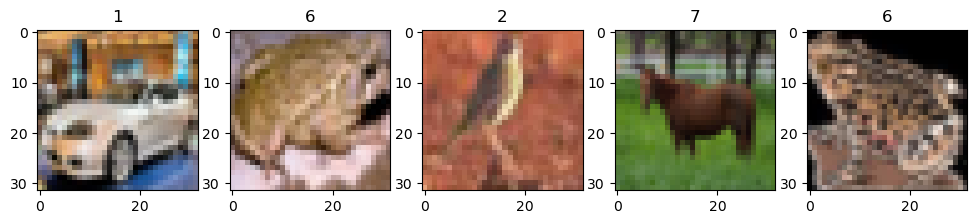

In [ ]:
n = 5

k = [randint(0,50000) for k in range(n)]

figure = plt.figure(figsize=(12, 12))

for i,j in enumerate(k):
    figure.add_subplot(1, n, i+1)
    plt.title(train_initial.targets[j])
    plt.imshow(train_initial.data[j])


Check the number of class in the training data and count the number of observations per each class.

In [ ]:
label_count = pd.DataFrame(train_initial.targets)
label_count.value_counts()

0
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64

There are 10 classes, each with 5000 observations. Convert these images to tensors.

In [ ]:
transform = transforms.ToTensor()

train_tensor = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\train" , train = True, transform = transform, download = False)
test_tensor = datasets.CIFAR10(root = "C:\\Users\\Sven\\Desktop\\CS_985_project\\test", train = False, transform = transform, download = False)

### Image interpolation

As images are of low resolution, interpolation is considered. The resolution of images is incread from 32 by 32 to 64 by 64 using "bilinear" interpolation. The obtained interpolated images are saved in the new data set im_inerpolated.

In [ ]:
train_loaded = DataLoader(train_tensor, batch_size = len(train_initial), shuffle = False)

im_original, lab = next(iter(train_loaded))

im_interpolated = F.interpolate(im_original, size = (64,64), mode='bilinear')

Verify the interpolation worked by checking the size of the obtained data set.

In [ ]:
im_interpolated.shape

torch.Size([50000, 3, 64, 64])

Note that the new data set contains the same number of observations and channels with the increased image resolution. To compare the interpolated and the original low-resolution image, the first five observations from the training data are displayed.

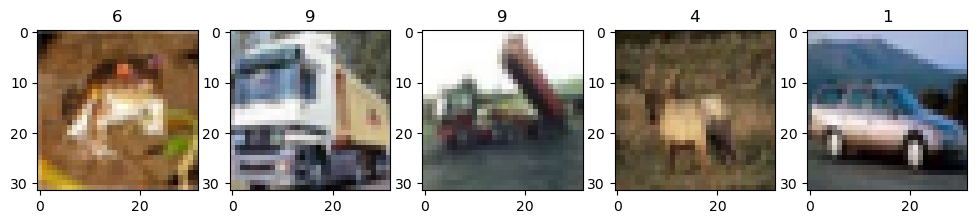

In [ ]:
# Original images

figure = plt.figure(figsize=(12, 12))

for i in range(5):
    figure.add_subplot(1, 5, i+1)
    img_ = im_original[i].permute(1, 2, 0).numpy()
    plt.title(lab[i].item())
    plt.imshow(img_)

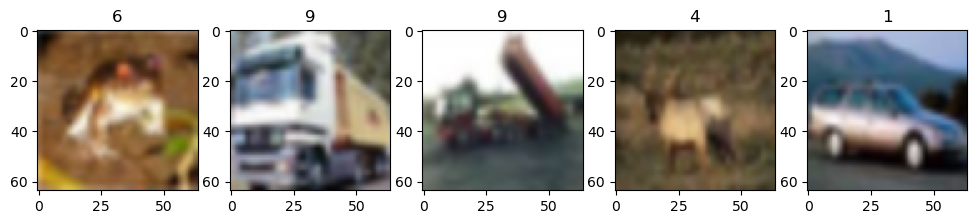

In [ ]:
# Interpolated images

figure = plt.figure(figsize=(12, 12))

for i in range(5):
    figure.add_subplot(1, 5, i+1)
    img_ = im_interpolated[i].permute(1, 2, 0).numpy() # rearranges the positions of dimensions
    plt.title(lab[i].item())
    plt.imshow(img_)

### Tranining and Validation split

The whole training data is split into two data sets: truncated training data and validation data. The split is done using 85/15 ratio. The initial model training is done on the truncated training data, and the evaluation is performed on the validation set. Once the best model is found on the validation set, it is then retrained using the whole training data and is evaluated on the test data.


In [ ]:
generator1 = torch.Generator().manual_seed(42) # The seed is set to always obtaing the same two sets

X_train_inter, X_val_inter, y_train_inter, y_val_inter = train_test_split(im_interpolated, lab, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(im_original, lab, test_size=0.15, random_state=42)

Display the size of the obatined data sets.

In [ ]:
print(f"The size of truncated training data is: {len(X_train)}.")
print(f"The size of validation data is: {len(X_val)}.")

The size of truncated training data is: 42500.
The size of validation data is: 7500.


### Geometric augmentation transforms

To introduce more variance in the training data during training, geometric augmentation transforms are defined and applied with some pre-defined probability on batches during training. This should result in a more robust models, along with preventing the models from trying to learn the data.

In [ ]:
im_rotation = torchvision.transforms.RandomRotation((-35,35), interpolation = torchvision.transforms.InterpolationMode.BILINEAR)

batch_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.15),
    transforms.RandomApply([im_rotation], p = 0.8)])

### Early Stop and model save point

Early stop function is defined to stop the model training after a certain number of epochs without some minimum improvement. If this minimum improvement occurs, the model is saved to a pre-defined location.

In [ ]:
def EarlyStop(loss_value, best_loss, counter, model, checkpoint_path, minimum_inprovement = 0.05):
    if best_loss - loss_value >= minimum_inprovement:
        best_loss = loss_value
        counter = 0
        torch.save(model, checkpoint_path) # Saves the current best model
    else:
        counter += 1

    return counter, best_loss

### Model validation function

After each training epoch, of interest is models' performance on validation data. To measure it below is defined model_validation function. It measures models' validation accuracy and loss.

In [ ]:
# Format the validation data, both interpolated and the original sets

# Original validation data
valid_set = torch.utils.data.TensorDataset(X_val, y_val)
valid_loaded =  DataLoader(valid_set, batch_size = 64, shuffle=False)

# Interpolated validation data
valid_set_inter = torch.utils.data.TensorDataset(X_val_inter, y_val_inter)
valid_loaded_inter =  DataLoader(valid_set_inter, batch_size = 64, shuffle=False)

# Validation function

def model_validation(val_data, model_to_ev, criterion):
    model_to_ev.eval()
    val_loss = 0
    correct = 0

    for i, (images, labels) in enumerate(val_data):
        images, labels = images.to(device), labels.to(device)
        pred = model_to_ev(images)
        loss_ = criterion(pred, labels)
        val_loss += loss_.item()
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

    val_loss = val_loss/len(val_data)
    acc = correct/len(valid_loaded_inter.dataset)
    return acc, val_loss

### Traning functions

Two training functions are defined, one that applies augmentation and one that does not apply the augmentation to input batches. Note that this could have been defined as one function with additional bool argument stating whether to implement then augmentation or not. However, defining the two functions with different names made the code more readable.

In [ ]:
def train(num_epochs, model, data_loaded, validation_loaded, checkpoint_path, loss_func, optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0):
    model.train()

    for epoch in range(num_epochs):

        loss_acc = 0 # For tracking the loss at each epoch
        n = len(data_loaded)

        for i, (images, labels) in enumerate(data_loaded):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            loss_acc += loss

        loss_acc = loss_acc/n  # Lost over the whole training data
        training_loss.append(loss_acc.item())

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss_acc))

        val_accuracy_, valid_loss_ = model_validation(validation_loaded, model, loss_func)

        print(f"Validation accuracy: {val_accuracy_*100:.2f}%.")
        # print(f"Validation loss: {valid_loss_:.4f}.")


        valid_loss.append(valid_loss_)
        val_accuracy.append(val_accuracy_)

        if epoch == 0:
            best_loss = valid_loss_
            torch.save(model, checkpoint_path)
            print("\n")
        else:
            counter, best_loss = EarlyStop(valid_loss_, best_loss, counter, model, checkpoint_path)
            print(f"The number of epochs without improvement: {counter}.\n")

        if counter == tolerance:
            print(f"The training stopped after {epoch} epochs.")
            return valid_loss, val_accuracy, training_loss

In [ ]:
def augment_transform(images, transforms_):
    transformed_batch = torch.stack([transforms_(x) for x in images])
    return transformed_batch

def train_aug(num_epochs, model, data_loaded, validation_loaded, checkpoint_path, loss_func, optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0):
    model.train()

    for epoch in range(num_epochs):

        loss_acc = 0 # For tracking the loss at each epoch
        n = len(data_loaded)

        for i, (images, labels) in enumerate(data_loaded):
            images, labels = images.to(device), labels.to(device)
            images = augment_transform(images = images, transforms_ = batch_augmentation)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            loss_acc += loss

        loss_acc = loss_acc/n  # Lost over the whole training data
        training_loss.append(loss_acc.item())

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss_acc))

        val_accuracy_, valid_loss_ = model_validation(validation_loaded, model, loss_func)

        print(f"Validation accuracy: {val_accuracy_*100:.2f}%.")
        # print(f"Validation loss: {valid_loss_:.4f}.")


        valid_loss.append(valid_loss_)
        val_accuracy.append(val_accuracy_)

        if epoch == 0:
            best_loss = valid_loss_
            torch.save(model, checkpoint_path)
            print("\n")
        else:
            counter, best_loss = EarlyStop(valid_loss_, best_loss, counter, model, checkpoint_path)
            print(f"The number of epochs without improvement: {counter}.\n")

        if counter == tolerance:
            print(f"The training stopped after {epoch} epochs.")
            return valid_loss, val_accuracy, training_loss

# Part 1: CNN

## Architectures

In the following three different CNN models are defined. All three models are defined with bool __interpolated__ argument, which if __True__ adjusts the model architecture for the interpolated inputs.

### First model

The first model has two convolution layers with 64 and 128 channels respectively. Each convolution layer is followed by ReLU activation function and MaxPool layer. The output of the second convolution layer is flattened and images are classified in the final layer. Between the two convolution layers, and the second conovolution and the last layer, dropouts are applied with the probability of 20%. These randomly delete some of the connections between the layers with pre-defined probability (here 20%). Applying dropouts should make the model more robust and ensure that the model does not only rely on few dominant features but rather learns multiple representations of the underlying data.

In [ ]:
class CNN_1(nn.Module):
    def __init__(self, interpolated):
        super().__init__()
        if interpolated:            # Interpolated images are twice the resolution, and hence we are required to adjust the final nn.Linear layers input size
            n = 2
        else:
            n = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=64, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.drop = nn.Dropout(p = 0.2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.out = nn.Linear(128 * 8 * 8 * n * n, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(self.drop(x))
        x = x.view(x.size(0), -1)
        output = self.out(self.drop(x))
        return output

### Second model

The second model is almost identical to the first model. The only difference between the two models is that the depth of the two convolution layers has doubled.

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, interpolated):
        super().__init__()
        if interpolated:            # Interpolated images are twice the resolution, and hence we are required to adjust the final nn.Linear layers input size
            n = 2
        else:
            n = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels= 64 * 2, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.drop = nn.Dropout(p = 0.2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64 *2, out_channels = 128 * 2, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.out = nn.Linear(128 * 2 * 8 * 8 * n * n, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(self.drop(x))
        x = x.view(x.size(0), -1)
        output = self.out(self.drop(x))
        return output

### Third model

In the third model an additional convolution layer has been added. The depths of the three convolutional layers are: 128, 256 and 256.

In [ ]:
# Additional covolutional layer added

class CNN_3(nn.Module):
    def __init__(self, interpolated):
        super().__init__()
        if interpolated:            # Interpolated images are twice the resolution, and hence we are required to adjust the final nn.Linear layers input size
            n = 2
        else:
            n = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels= 64 * 2, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.drop = nn.Dropout(p = 0.2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64 *2, out_channels = 128 * 2, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128 * 2, out_channels = 128 * 2, kernel_size = (3,3), stride = 1, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )

        self.out = nn.Linear(128 * 2 * 4 * 4 * n * n, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(self.drop(x))
        x = self.conv3(self.drop(x))
        x = x.view(x.size(0), -1)
        output = self.out(self.drop(x))
        return output

## 1. Training without augmentation or interpolation

In the following section, the three models are trained without using interpolation or augmentation. All models are trained with early stop patience of 7 and minimum improvement set to 0.05.

#### Model 1

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1.pth"), exist_ok = True)

model_1 = CNN_1(interpolated = False)
model_1.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_1_val_loss, model_1_val_accuracy, model_1_training_loss = train(num_epochs = 100, model = model_1, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.5643
Validation accuracy: 53.40%.


Epoch [2/100], Loss: 1.1836
Validation accuracy: 60.33%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.0275
Validation accuracy: 64.11%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 0.9266
Validation accuracy: 65.57%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 0.8610
Validation accuracy: 68.23%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 0.8039
Validation accuracy: 68.84%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 0.7594
Validation accuracy: 67.57%.
The number of epochs without improvement: 2.

Epoch [8/100], Loss: 0.7165
Validation accuracy: 69.35%.
The number of epochs without improvement: 3.

Epoch [9/100], Loss: 0.6781
Validation accuracy: 70.15%.
The number of epochs without improvement: 0.

Epoch [10/100], Loss: 0.6434
Validation accuracy: 70.23%.
The number of epochs without improvement: 1.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_loss)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_accuracy)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_training_loss)

In [ ]:
# Load the performance from a local csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_loss = next(reader)
    model_1_val_loss = [float(x) for x in model_1_val_loss]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_accuracy = next(reader)
    model_1_val_accuracy = [float(x) for x in model_1_val_accuracy]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_training_loss = next(reader)
    model_1_training_loss = [float(x) for x in model_1_training_loss]

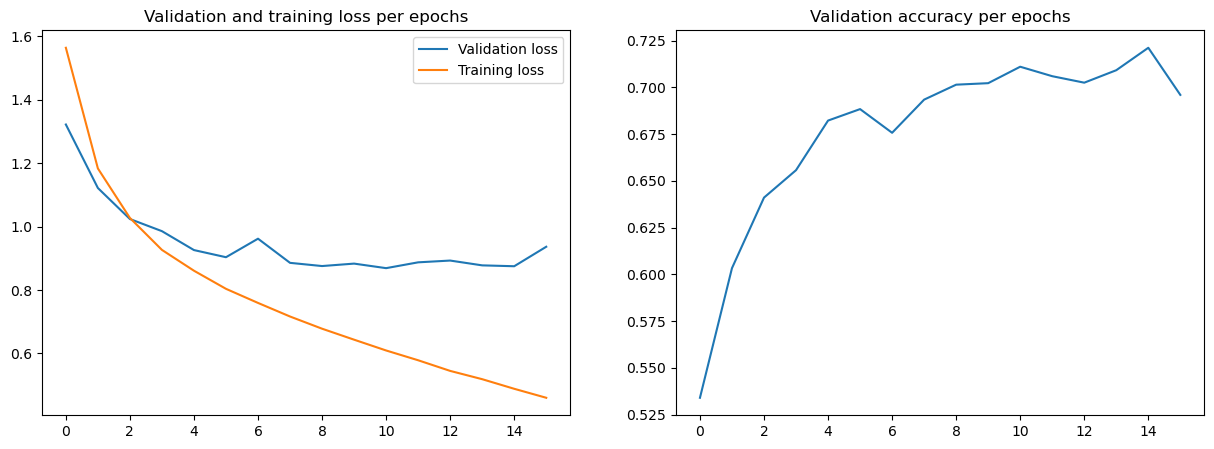

In [ ]:
# Model 1s' performance visualisation

no_of_epoch = list(range(len(model_1_val_loss)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_1_val_loss, label='Validation loss')
plt.plot(no_of_epoch, model_1_training_loss, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_1_val_accuracy)

In [ ]:
print(f"First models saved performance accuracy on validation set is: {model_1_val_accuracy[-8]*100:.2f}%.")

First models saved performance accuracy on validation set is: 70.15%.


The training stopped after 15 epochs. Validation loss had barely improved after 5th epoch, while event at later epochs the training loss was significantly improving. This indicates that the model started overfitting and early stop function was right to stop the training. At the best validation epoch, the models' validation accuracy was 70.15%.

#### Model 2

In [ ]:
# Model training

path_to_save_model = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1.pth"

os.makedirs(os.path.dirname(path_to_save_model), exist_ok = True)

model_2 = CNN_2(interpolated = False)
model_2.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_2_val_loss, model_2_val_accuracy, model_2_training_loss = train(num_epochs = 100, model = model_2, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = path_to_save_model, loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.5028
Validation accuracy: 56.47%.


Epoch [2/100], Loss: 1.1394
Validation accuracy: 62.35%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 0.9751
Validation accuracy: 66.37%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 0.8865
Validation accuracy: 66.95%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 0.8112
Validation accuracy: 65.83%.
The number of epochs without improvement: 2.

Epoch [6/100], Loss: 0.7504
Validation accuracy: 67.32%.
The number of epochs without improvement: 3.

Epoch [7/100], Loss: 0.6980
Validation accuracy: 70.68%.
The number of epochs without improvement: 0.

Epoch [8/100], Loss: 0.6473
Validation accuracy: 70.51%.
The number of epochs without improvement: 1.

Epoch [9/100], Loss: 0.6034
Validation accuracy: 71.35%.
The number of epochs without improvement: 2.

Epoch [10/100], Loss: 0.5618
Validation accuracy: 71.48%.
The number of epochs without improvement: 3.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_loss)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_accuracy)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_training_loss)


In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_loss = next(reader)
    model_2_val_loss = [float(x) for x in model_2_val_loss]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_accuracy = next(reader)
    model_2_val_accuracy = [float(x) for x in model_2_val_accuracy]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_training_loss = next(reader)
    model_2_training_loss = [float(x) for x in model_2_training_loss]

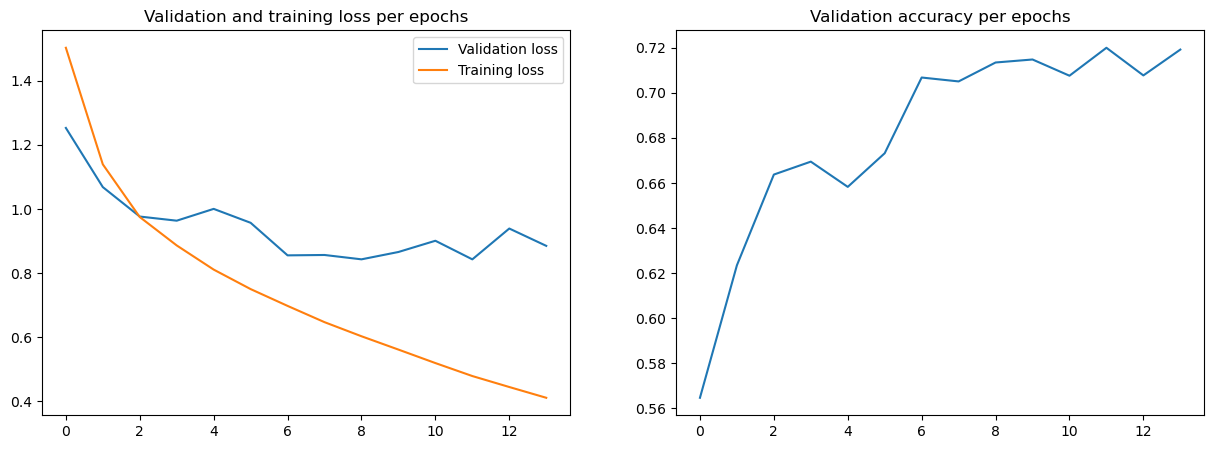

In [ ]:
# Model 2 performance visualisation

no_of_epoch = list(range(len(model_2_val_loss)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_2_val_loss, label='Validation loss')
plt.plot(no_of_epoch, model_2_training_loss, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_2_val_accuracy)

In [ ]:
# Model 2s' saved performance on validation set:

print(f"Second models saved performance accuracy on validation set is: {model_2_val_accuracy[-8]*100:.2f}%.")

Second models saved performance accuarcy on validation set is: 70.68%.


Despite the increased depth, the second model stop improving after fewer epochs than the first model and was stopped after the 13th epoch. Models' validation accuracy for the best epoch was 70.68%, which is roughly 0.5% better than the initial model.

#### Model 3

In [ ]:
# Model training

path_to_save_model = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1.pth"

os.makedirs(os.path.dirname(path_to_save_model), exist_ok = True)

model_3 = CNN_3(interpolated = False)
model_3.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_3_val_loss, model_3_val_accuracy, model_3_training_loss = train(num_epochs = 100, model = model_3, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = path_to_save_model, loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.5967
Validation accuracy: 53.24%.


Epoch [2/100], Loss: 1.1395
Validation accuracy: 62.23%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 0.9472
Validation accuracy: 68.52%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 0.8198
Validation accuracy: 70.67%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 0.7197
Validation accuracy: 72.92%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 0.6399
Validation accuracy: 73.64%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 0.5812
Validation accuracy: 74.41%.
The number of epochs without improvement: 2.

Epoch [8/100], Loss: 0.5119
Validation accuracy: 74.28%.
The number of epochs without improvement: 3.

Epoch [9/100], Loss: 0.4521
Validation accuracy: 73.97%.
The number of epochs without improvement: 4.

Epoch [10/100], Loss: 0.3937
Validation accuracy: 75.77%.
The number of epochs without improvement: 5.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_loss)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_accuracy)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_training_loss)


In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_loss = next(reader)
    model_3_val_loss = [float(x) for x in model_3_val_loss]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_accuracy = next(reader)
    model_3_val_accuracy = [float(x) for x in model_3_val_accuracy]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_training_loss = next(reader)
    model_3_training_loss = [float(x) for x in model_3_training_loss]

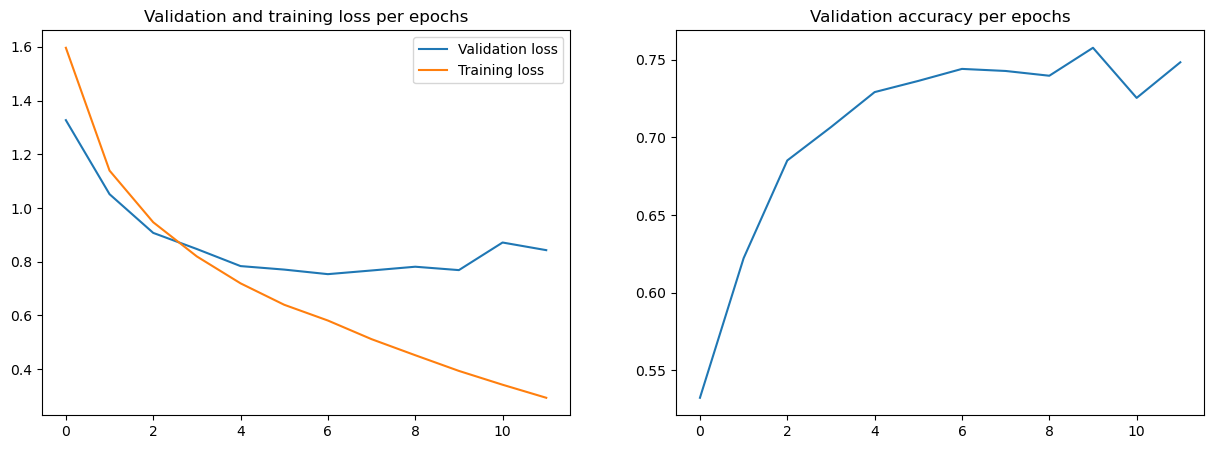

In [ ]:
# Model 3 performance visualisation

no_of_epoch = list(range(len(model_3_val_loss)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_3_val_loss, label='Validation loss')
plt.plot(no_of_epoch, model_3_training_loss, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_3_val_accuracy)

In [ ]:
# Model 3s' saved performance on validation set:

print(f"Third models saved performance accuracy on validation set is: {model_3_val_accuracy[-8]*100:.2f}%.")

Third models saved performance accuarcy on validation set is: 72.92%.


Again, the increased model complexity did not result in more training epochs. The third model was stopped after only 11 epochs. However, the model did outperform the first the models by more than 2% and has achieved 72.92% accuracy for the best epoch.

All three models were trained in under few minutes despite the large number of observations in the training data. This can mainly be attributed to low resolution of training images.

### 2. Training without augmentation, but with interpolation

#### Model 1

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2.pth"), exist_ok = True)

model_1_inter = CNN_1(interpolated = True)
model_1_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_1_val_loss_inter, model_1_val_accuracy_inter, model_1_training_loss_inter = train(num_epochs = 100, model = model_1_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.6415
Validation accuracy: 50.91%.


Epoch [2/100], Loss: 1.2838
Validation accuracy: 56.09%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.1559
Validation accuracy: 58.64%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.0751
Validation accuracy: 60.13%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 0.9988
Validation accuracy: 62.41%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 0.9351
Validation accuracy: 63.60%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 0.8704
Validation accuracy: 62.48%.
The number of epochs without improvement: 2.

Epoch [8/100], Loss: 0.8234
Validation accuracy: 65.24%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 0.7739
Validation accuracy: 65.28%.
The number of epochs without improvement: 1.

Epoch [10/100], Loss: 0.7315
Validation accuracy: 66.05%.
The number of epochs without improvement: 2.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_loss_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_accuracy_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_training_loss_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_loss_inter = next(reader)
    model_1_val_loss_inter = [float(x) for x in model_1_val_loss_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_accuracy_inter = next(reader)
    model_1_val_accuracy_inter = [float(x) for x in model_1_val_accuracy_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_2_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_training_loss_inter = next(reader)
    model_1_training_loss_inter = [float(x) for x in model_1_training_loss_inter]

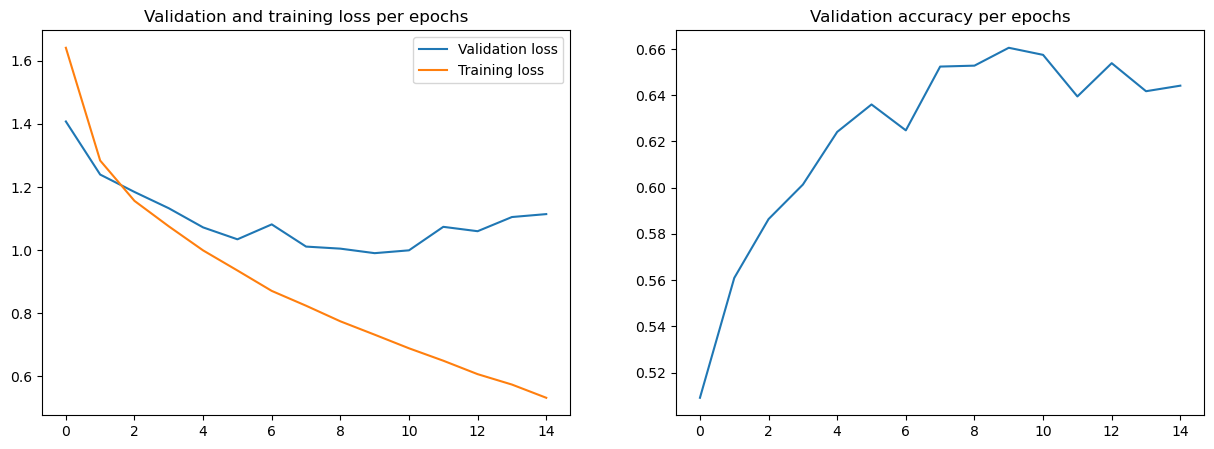

In [ ]:
# Model 1 performance visualisation

no_of_epoch = list(range(len(model_1_val_loss_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_1_val_loss_inter, label='Validation loss')
plt.plot(no_of_epoch, model_1_training_loss_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_1_val_accuracy_inter)

In [ ]:
# Model 1s' saved performance on validation set:

print(f"First models saved performance accuracy on validation set is: {model_1_val_accuracy_inter[-8]*100:.2f}%.")

First models saved performance accuarcy on validation set is: 65.24%.


Interpolation did not improve the first models' performance, on contrary, the model performed roughly 5% worse. Further, perhaps surprisingly, the model training was once again stopped at an early epoch and the model only trained for 14 epochs.

#### Model 2

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2.pth"), exist_ok = True)

model_2_inter = CNN_2(interpolated = True)
model_2_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_2_val_loss_inter, model_2_val_accuracy_inter, model_2_training_loss_inter = train(num_epochs = 100, model = model_2_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.6302
Validation accuracy: 51.12%.


Epoch [2/100], Loss: 1.3026
Validation accuracy: 54.60%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.1658
Validation accuracy: 59.41%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.0952
Validation accuracy: 59.65%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 1.0316
Validation accuracy: 61.95%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 0.9750
Validation accuracy: 62.93%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 0.9296
Validation accuracy: 63.89%.
The number of epochs without improvement: 0.

Epoch [8/100], Loss: 0.8899
Validation accuracy: 64.09%.
The number of epochs without improvement: 1.

Epoch [9/100], Loss: 0.8521
Validation accuracy: 64.52%.
The number of epochs without improvement: 2.

Epoch [10/100], Loss: 0.8235
Validation accuracy: 65.09%.
The number of epochs without improvement: 3.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_loss_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_accuracy_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_training_loss_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_loss_inter = next(reader)
    model_2_val_loss_inter = [float(x) for x in model_2_val_loss_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_accuracy_inter = next(reader)
    model_2_val_accuracy_inter = [float(x) for x in model_2_val_accuracy_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_2_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_training_loss_inter = next(reader)
    model_2_training_loss_inter = [float(x) for x in model_2_training_loss_inter]

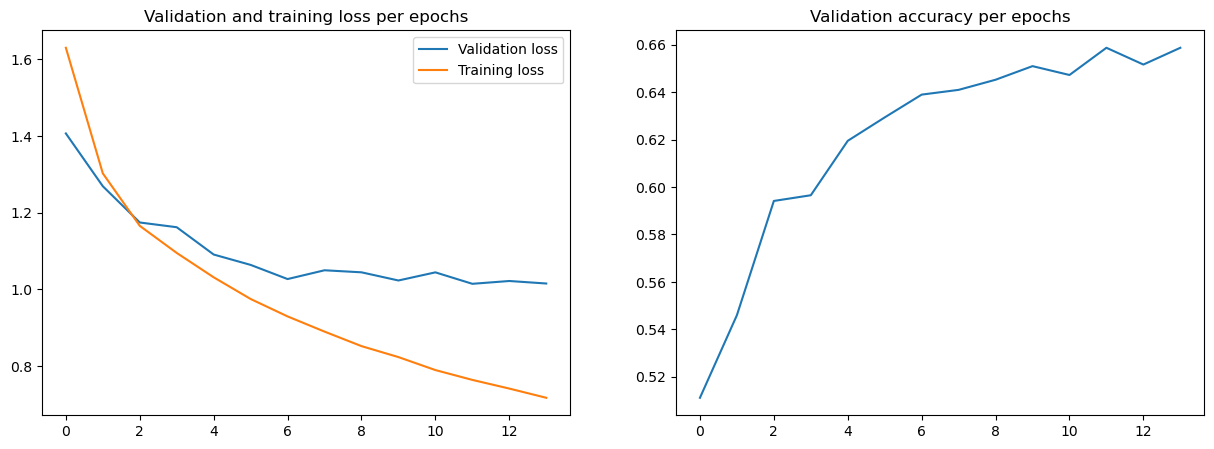

In [ ]:
# Model 2 performance visualisation

no_of_epoch = list(range(len(model_2_val_loss_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_2_val_loss_inter, label='Validation loss')
plt.plot(no_of_epoch, model_2_training_loss_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_2_val_accuracy_inter)

In [ ]:
# Model 2s' saved performance on validation set:

print(f"Second models' saved performance accuracy on validation set is: {model_2_val_accuracy_inter[-8]*100:.2f}%.")

Second models' saved performance accuarcy on validation set is: 63.89%.


Similarly to the first model, interpolation has decreased the models' performance significantly.

#### Model 3

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2.pth"), exist_ok = True)

model_3_inter = CNN_3(interpolated = True)
model_3_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_3_val_loss_inter, model_3_val_accuracy_inter, model_3_training_loss_inter = train(num_epochs = 100, model = model_3_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.5905
Validation accuracy: 52.19%.


Epoch [2/100], Loss: 1.1955
Validation accuracy: 60.96%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.0052
Validation accuracy: 65.19%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 0.8883
Validation accuracy: 68.15%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 0.8012
Validation accuracy: 69.67%.
The number of epochs without improvement: 1.

Epoch [6/100], Loss: 0.7322
Validation accuracy: 68.80%.
The number of epochs without improvement: 2.

Epoch [7/100], Loss: 0.6697
Validation accuracy: 71.44%.
The number of epochs without improvement: 0.

Epoch [8/100], Loss: 0.6158
Validation accuracy: 71.77%.
The number of epochs without improvement: 1.

Epoch [9/100], Loss: 0.5655
Validation accuracy: 71.04%.
The number of epochs without improvement: 2.

Epoch [10/100], Loss: 0.5195
Validation accuracy: 71.37%.
The number of epochs without improvement: 3.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_loss_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_accuracy_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_training_loss_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_loss_inter = next(reader)
    model_3_val_loss_inter = [float(x) for x in model_3_val_loss_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_accuracy_inter = next(reader)
    model_3_val_accuracy_inter = [float(x) for x in model_3_val_accuracy_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_2_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_training_loss_inter = next(reader)
    model_3_training_loss_inter = [float(x) for x in model_3_training_loss_inter]

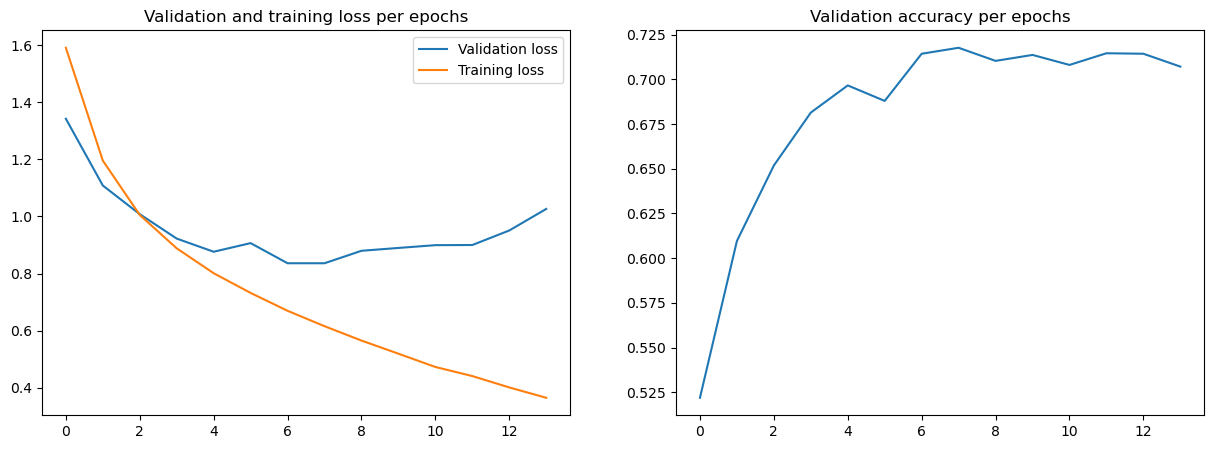

In [ ]:
# Model 3 performance visualisation

no_of_epoch = list(range(len(model_3_val_loss_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_3_val_loss_inter, label='Validation loss')
plt.plot(no_of_epoch, model_3_training_loss_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_3_val_accuracy_inter)

In [ ]:
# Model 3s' saved performance on validation set:

print(f"Third models' saved performance accuracy on validation set is: {model_3_val_accuracy_inter[-8]*100:.2f}%.")

Third models' saved performance accuarcy on validation set is: 71.44%.


The third model was the only one to perform similarly for both the original data and interpolated data. However, as in the first two models, its performance was worse when trained on interpolated data by roughly 1.5%.

Applying interpolation to the training data has reduced the performance of all three models and had roughly increased the training time by a factor of four.

### 3. Training with augmentation, but without upscaling

Applying augmentation randomly to batches of images during training should result in more robust models.

#### Model 1

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3.pth"), exist_ok = True)

model_1_aug = CNN_1(interpolated = False)
model_1_aug.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_aug.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_1_val_loss_aug, model_1_val_accuracy_aug, model_1_training_loss_aug = train_aug(num_epochs = 100, model = model_1_aug, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7225
Validation accuracy: 49.97%.


Epoch [2/100], Loss: 1.4354
Validation accuracy: 54.08%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.3292
Validation accuracy: 56.75%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.2666
Validation accuracy: 62.64%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 1.2161
Validation accuracy: 64.75%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 1.1716
Validation accuracy: 63.68%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 1.1377
Validation accuracy: 66.07%.
The number of epochs without improvement: 0.

Epoch [8/100], Loss: 1.1049
Validation accuracy: 67.73%.
The number of epochs without improvement: 1.

Epoch [9/100], Loss: 1.0776
Validation accuracy: 67.99%.
The number of epochs without improvement: 0.

Epoch [10/100], Loss: 1.0585
Validation accuracy: 67.24%.
The number of epochs without improvement: 1.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_loss_aug)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_accuracy_aug)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_training_loss_aug)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_loss_aug = next(reader)
    model_1_val_loss_aug = [float(x) for x in model_1_val_loss_aug]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_accuracy_aug = next(reader)
    model_1_val_accuracy_aug = [float(x) for x in model_1_val_accuracy_aug]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_3_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_training_loss_aug = next(reader)
    model_1_training_loss_aug = [float(x) for x in model_1_training_loss_aug]

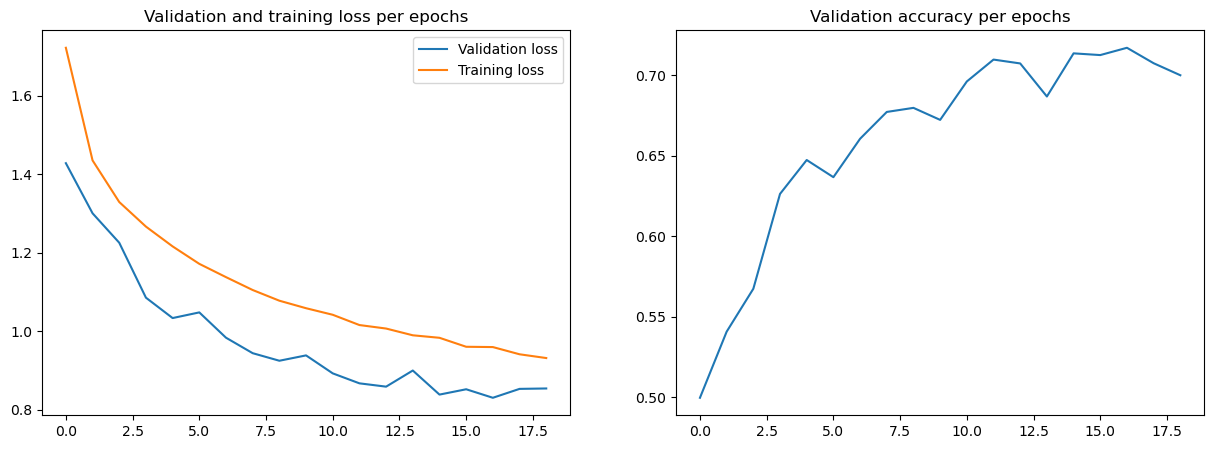

In [ ]:
# Model 1 performance visualisation

no_of_epoch = list(range(len(model_1_val_loss_aug)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_1_val_loss_aug, label='Validation loss')
plt.plot(no_of_epoch, model_1_training_loss_aug, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_1_val_accuracy_aug)

In [ ]:
# Model 1s' saved performance on validation set:

print(f"First models saved performance accuracy on validation set is: {model_1_val_accuracy_aug[-8]*100:.2f}%.")

First models saved performance accuarcy on validation set is: 70.99%.


The first model has outperformed its best previous run (the first run), by roughly 0.85%. Further, the model did not overfit to the training data as can be noted from the provided figure above. In addition to this, the training lasted 18 epochs, which was longer than any previous training.

#### Model 2

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3.pth"), exist_ok = True)

model_2_aug = CNN_2(interpolated = False)
model_2_aug.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_aug.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_2_val_loss_aug, model_2_val_accuracy_aug, model_2_training_loss_aug = train_aug(num_epochs = 100, model = model_2_aug, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7070
Validation accuracy: 49.33%.


Epoch [2/100], Loss: 1.4170
Validation accuracy: 56.81%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.3156
Validation accuracy: 59.77%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.2453
Validation accuracy: 62.40%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 1.2031
Validation accuracy: 63.33%.
The number of epochs without improvement: 1.

Epoch [6/100], Loss: 1.1671
Validation accuracy: 64.49%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 1.1313
Validation accuracy: 65.21%.
The number of epochs without improvement: 1.

Epoch [8/100], Loss: 1.1095
Validation accuracy: 67.08%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 1.0816
Validation accuracy: 69.11%.
The number of epochs without improvement: 0.

Epoch [10/100], Loss: 1.0607
Validation accuracy: 66.71%.
The number of epochs without improvement: 1.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_loss_aug)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_accuracy_aug)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_training_loss_aug)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_loss_aug = next(reader)
    model_2_val_loss_aug = [float(x) for x in model_2_val_loss_aug]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_accuracy_aug = next(reader)
    model_2_val_accuracy_aug = [float(x) for x in model_2_val_accuracy_aug]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_3_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_training_loss_aug = next(reader)
    model_2_training_loss_aug = [float(x) for x in model_2_training_loss_aug]

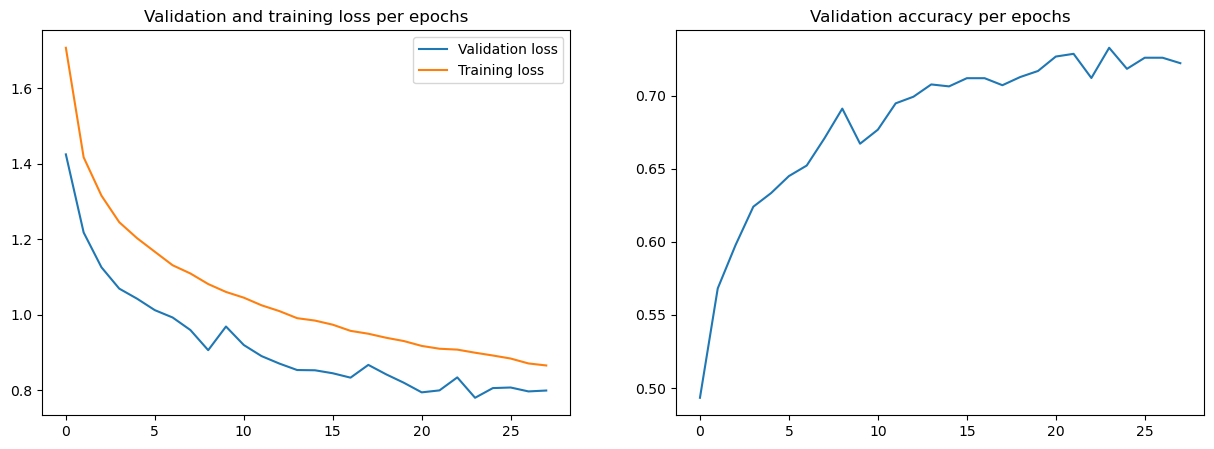

In [ ]:
# Model 2 performance visualisation

no_of_epoch = list(range(len(model_2_val_loss_aug)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_2_val_loss_aug, label='Validation loss')
plt.plot(no_of_epoch, model_2_training_loss_aug, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_2_val_accuracy_aug)

In [ ]:
# Model 2s' saved performance on validation set:

print(f"Second models saved performance accuracy on validation set is: {model_2_val_accuracy_aug[-8]*100:.2f}%.")

Second models saved performance accuarcy on validation set is: 72.67%.


As in the case for the first model, the second model has outperformed all its previous runs. The training was run for 27 epochs, which is significantly longer than any previous models' run. Further, the model does not overfit for the training data, as can be seen in the figure, where validation loss is always below the training loss.

#### Model 3

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3.pth"), exist_ok = True)

model_3_aug = CNN_3(interpolated = False)
model_3_aug.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_aug.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train, y_train)
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_3_val_loss_aug, model_3_val_accuracy_aug, model_3_training_loss_aug = train_aug(num_epochs = 100, model = model_3_aug, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7495
Validation accuracy: 48.92%.


Epoch [2/100], Loss: 1.4094
Validation accuracy: 57.57%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.2680
Validation accuracy: 62.95%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.1686
Validation accuracy: 64.21%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 1.1021
Validation accuracy: 65.01%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 1.0460
Validation accuracy: 67.44%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 1.0006
Validation accuracy: 70.08%.
The number of epochs without improvement: 0.

Epoch [8/100], Loss: 0.9634
Validation accuracy: 71.56%.
The number of epochs without improvement: 1.

Epoch [9/100], Loss: 0.9299
Validation accuracy: 71.56%.
The number of epochs without improvement: 2.

Epoch [10/100], Loss: 0.9099
Validation accuracy: 72.49%.
The number of epochs without improvement: 0.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_loss_aug)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_accuracy_aug)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_training_loss_aug)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_loss_aug = next(reader)
    model_3_val_loss_aug = [float(x) for x in model_3_val_loss_aug]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_accuracy_aug = next(reader)
    model_3_val_accuracy_aug = [float(x) for x in model_3_val_accuracy_aug]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_3_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_training_loss_aug = next(reader)
    model_3_training_loss_aug = [float(x) for x in model_3_training_loss_aug]

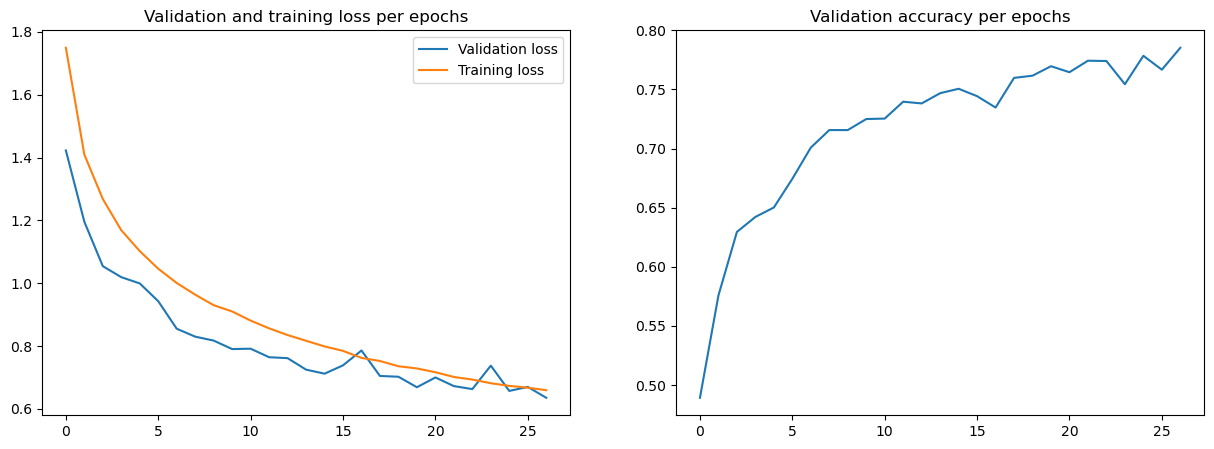

In [ ]:
# Model 3 performance visualisation

no_of_epoch = list(range(len(model_3_val_loss_aug)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_3_val_loss_aug, label='Validation loss')
plt.plot(no_of_epoch, model_3_training_loss_aug, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_3_val_accuracy_aug)

In [ ]:
# Model 3s' saved performance on validation set:

print(f"Third models' saved performance accuracy on validation set is: {model_3_val_accuracy_aug[-8]*100:.2f}%.")

Third models saved performance accuracy on validation set is: 76.96%.


The third model outperformed all the previous models by roughly 4% without overfitting for the training data. The model was trained for 26 epochs and achieved validation accuracy of 76.96% for its best epoch.

Applying data augmentation to training data has improved the performance of all three models and has prevented models from overfitting to training data. The computational cost of implementing augmentation on each batch has increased the training time compared to the first run. However, this was still significantly lower than the training time of the second run (using interpolation).

### 4. Training with both augmentation and interpolation

Based on the third run, it is expected that the fourth run with outperform the second run. However, it is also expected that this run will be significantly more computationally complex then the previous three runs.

#### Model 1

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4.pth"), exist_ok = True)

model_1_aug_inter = CNN_1(interpolated = True)
model_1_aug_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_aug_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_1_val_loss_aug_inter, model_1_val_accuracy_aug_inter, model_1_training_loss_aug_inter = train_aug(num_epochs = 100, model = model_1_aug_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7731
Validation accuracy: 48.25%.


Epoch [2/100], Loss: 1.5142
Validation accuracy: 51.32%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.4292
Validation accuracy: 54.49%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.3807
Validation accuracy: 55.89%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 1.3409
Validation accuracy: 56.95%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 1.3082
Validation accuracy: 58.00%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 1.2854
Validation accuracy: 58.69%.
The number of epochs without improvement: 2.

Epoch [8/100], Loss: 1.2526
Validation accuracy: 59.35%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 1.2301
Validation accuracy: 61.19%.
The number of epochs without improvement: 1.

Epoch [10/100], Loss: 1.2143
Validation accuracy: 61.08%.
The number of epochs without improvement: 2.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_loss_aug_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_val_accuracy_aug_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_1_training_loss_aug_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_loss_aug_inter = next(reader)
    model_1_val_loss_aug_inter = [float(x) for x in model_1_val_loss_aug_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_val_accuracy_aug_inter = next(reader)
    model_1_val_accuracy_aug_inter = [float(x) for x in model_1_val_accuracy_aug_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_1\\Train_4_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_1_training_loss_aug_inter = next(reader)
    model_1_training_loss_aug_inter= [float(x) for x in model_1_training_loss_aug_inter]

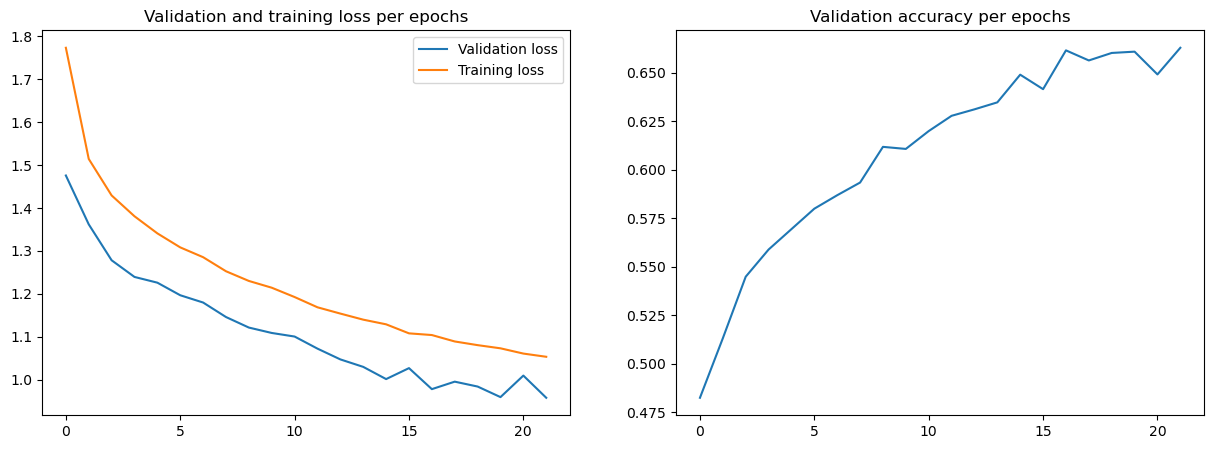

In [ ]:
# Model 1 performance visualisation

no_of_epoch = list(range(len(model_1_val_loss_aug_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_1_val_loss_aug_inter, label='Validation loss')
plt.plot(no_of_epoch, model_1_training_loss_aug_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_1_val_accuracy_aug_inter)

In [ ]:
# Model 1s' saved performance on validation set:

print(f"First models' saved performance accuracy on validation set is: {model_1_val_accuracy_aug_inter[-8]*100:.2f}%.")

First models' saved performance accuracy on validation set is: 64.91%.


Augmentation has stopped the overfitting to training data which occurred in the second run (also using interpolation) of the first model. However, the model was again performed poorly compared to its best run.

#### Model 2

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4.pth"), exist_ok = True)

model_2_aug_inter = CNN_2(interpolated = True)
model_2_aug_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_aug_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_2_val_loss_aug_inter, model_2_val_accuracy_aug_inter, model_2_training_loss_aug_inter = train_aug(num_epochs = 100, model = model_2_aug_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.8000
Validation accuracy: 46.37%.


Epoch [2/100], Loss: 1.5488
Validation accuracy: 50.41%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.4635
Validation accuracy: 53.17%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.4011
Validation accuracy: 54.89%.
The number of epochs without improvement: 1.

Epoch [5/100], Loss: 1.3739
Validation accuracy: 54.93%.
The number of epochs without improvement: 2.

Epoch [6/100], Loss: 1.3487
Validation accuracy: 56.80%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 1.3317
Validation accuracy: 57.53%.
The number of epochs without improvement: 1.

Epoch [8/100], Loss: 1.3122
Validation accuracy: 57.09%.
The number of epochs without improvement: 2.

Epoch [9/100], Loss: 1.2991
Validation accuracy: 58.41%.
The number of epochs without improvement: 3.

Epoch [10/100], Loss: 1.2800
Validation accuracy: 59.00%.
The number of epochs without improvement: 4.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_loss_aug_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_val_accuracy_aug_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_2_training_loss_aug_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_loss_aug_inter = next(reader)
    model_2_val_loss_aug_inter = [float(x) for x in model_2_val_loss_aug_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_val_accuracy_aug_inter = next(reader)
    model_2_val_accuracy_aug_inter = [float(x) for x in model_2_val_accuracy_aug_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_2\\Train_4_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_2_training_loss_aug_inter = next(reader)
    model_2_training_loss_aug_inter= [float(x) for x in model_2_training_loss_aug_inter]

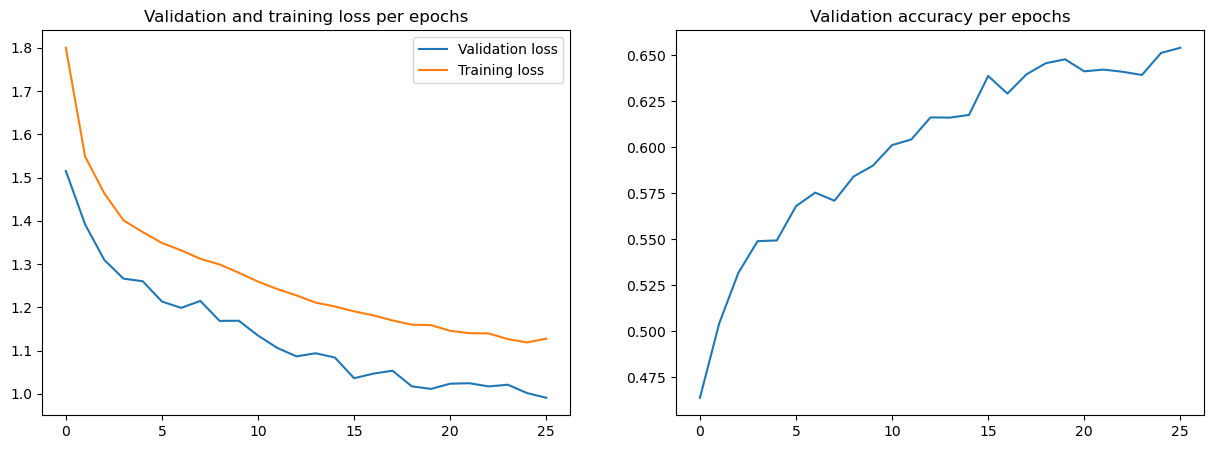

In [ ]:
# Model 2 performance visualisation

no_of_epoch = list(range(len(model_2_val_loss_aug_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_2_val_loss_aug_inter, label='Validation loss')
plt.plot(no_of_epoch, model_2_training_loss_aug_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_2_val_accuracy_aug_inter)

In [ ]:
# Model 2s' saved performance on validation set:

print(f"Seconds models' saved performance accuracy on validation set is: {model_2_val_accuracy_aug_inter[-8]*100:.2f}%.")

Seconds models' saved performance accuracy on validation set is: 64.57%.


Similarly to the first model, augmentation has prevented overfitting, but the overall model performance with interpolation was poor compared to runs one and three.

#### Model 3

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4.pth"), exist_ok = True)

model_3_aug_inter = CNN_3(interpolated = True)
model_3_aug_inter.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_aug_inter.parameters(), lr = 0.0005)


trianing_trunc = torch.utils.data.TensorDataset(X_train_inter, y_train_inter) # Note the inputs are X and y interpolated
train_truncated_loaded = DataLoader(trianing_trunc, batch_size = 64, shuffle = True)

model_3_val_loss_aug_inter, model_3_val_accuracy_aug_inter, model_3_training_loss_aug_inter = train_aug(num_epochs = 100, model = model_3_aug_inter, data_loaded = train_truncated_loaded, validation_loaded = valid_loaded_inter, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7363
Validation accuracy: 47.55%.


Epoch [2/100], Loss: 1.4399
Validation accuracy: 55.47%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.3217
Validation accuracy: 58.65%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.2386
Validation accuracy: 60.27%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 1.1634
Validation accuracy: 63.15%.
The number of epochs without improvement: 1.

Epoch [6/100], Loss: 1.1218
Validation accuracy: 66.77%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 1.0739
Validation accuracy: 67.68%.
The number of epochs without improvement: 1.

Epoch [8/100], Loss: 1.0378
Validation accuracy: 68.71%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 1.0117
Validation accuracy: 69.31%.
The number of epochs without improvement: 1.

Epoch [10/100], Loss: 0.9934
Validation accuracy: 66.76%.
The number of epochs without improvement: 2.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_loss_aug_inter)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_val_accuracy_aug_inter)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_3_training_loss_aug_inter)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_loss_aug_inter = next(reader)
    model_3_val_loss_aug_inter = [float(x) for x in model_3_val_loss_aug_inter]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_val_accuracy_aug_inter = next(reader)
    model_3_val_accuracy_aug_inter = [float(x) for x in model_3_val_accuracy_aug_inter]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_3\\Train_4_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_3_training_loss_aug_inter = next(reader)
    model_3_training_loss_aug_inter= [float(x) for x in model_3_training_loss_aug_inter]

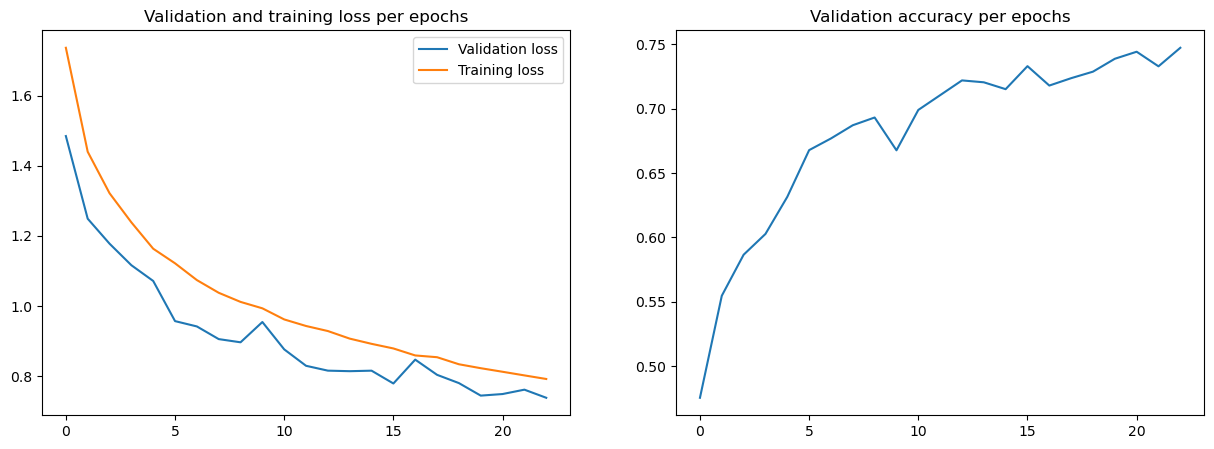

In [ ]:
# Model 3 performance visualisation

no_of_epoch = list(range(len(model_3_val_loss_aug_inter)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_3_val_loss_aug_inter, label='Validation loss')
plt.plot(no_of_epoch, model_3_training_loss_aug_inter, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_3_val_accuracy_aug_inter)

In [ ]:
# Model 3s' saved performance on validation set:

print(f"Third models' saved performance accuracy on validation set is: {model_3_val_accuracy_aug_inter[-8]*100:.2f}%.")

Third models' saved performance accuracy on validation set is: 73.29%.


Once again, the third model is the only one with competitive performance when trained on interpolated data. The overfitting problem was mitigated, however, the model still performed around 3.5% worse than its best run.

Considering that interpolation only worked well on the deepest model, perhaps further increasing the model complexity could yield better results.

### Retrain the best model

The best validation performance was achieved in the third model when trained with augmentation. The model is now retrained with the training data including the validation set and is evaluated on the test data.

Due to some overlooks in the code, validation and training functions had to be redefined to accommodate different size of test data compared to validation data.

In [ ]:
def model_validation_test(val_data, model_to_ev, criterion):
    model_to_ev.eval()
    val_loss = 0
    correct = 0

    for i, (images, labels) in enumerate(val_data):
        images, labels = images.to(device), labels.to(device)
        pred = model_to_ev(images)
        loss_ = criterion(pred, labels)
        val_loss += loss_.item()
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

    val_loss = val_loss/len(val_data)
    acc = correct/len(test_tensor.data)
    return acc, val_loss

In [ ]:
def train_aug_2(num_epochs, model, data_loaded, validation_loaded, checkpoint_path, loss_func, optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0):
    model.train()

    for epoch in range(num_epochs):

        loss_acc = 0 # For tracking the loss at each epoch
        n = len(data_loaded)

        for i, (images, labels) in enumerate(data_loaded):
            images, labels = images.to(device), labels.to(device)
            images = augment_transform(images = images, transforms_ = batch_augmentation)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            loss_acc += loss

        loss_acc = loss_acc/n  # Lost over the whole training data
        training_loss.append(loss_acc.item())

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss_acc))

        val_accuracy_, valid_loss_ = model_validation_test(validation_loaded, model, loss_func)

        print(f"Validation accuracy: {val_accuracy_*100:.2f}%.")
        # print(f"Validation loss: {valid_loss_:.4f}.")


        valid_loss.append(valid_loss_)
        val_accuracy.append(val_accuracy_)

        if epoch == 0:
            best_loss = valid_loss_
            torch.save(model, checkpoint_path)
            print("\n")
        else:
            counter, best_loss = EarlyStop(valid_loss_, best_loss, counter, model, checkpoint_path)
            print(f"The number of epochs without improvement: {counter}.\n")

        if counter == tolerance:
            print(f"The training stopped after {epoch} epochs.")
            return valid_loss, val_accuracy, training_loss

In [ ]:
# Model training

os.makedirs(os.path.dirname("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1.pth"), exist_ok = True)

model_CNN_final = CNN_3(interpolated = False)
model_CNN_final.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN_final.parameters(), lr = 0.0005)

test_loaded = DataLoader(test_tensor, batch_size = 64, shuffle = True)

trianing_whole_set = torch.utils.data.TensorDataset(im_original, lab)
trianing_whole_set_loaded = DataLoader(trianing_whole_set, batch_size = 64, shuffle = True)

model_CNN_final_val_loss_aug, model_CNN_final_val_accuracy_aug, model_CNN_final_training_loss_aug = train_aug_2(num_epochs = 100, model = model_CNN_final, data_loaded = trianing_whole_set_loaded, validation_loaded = test_loaded, checkpoint_path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1.pth", loss_func = loss_func, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[])

Epoch [1/100], Loss: 1.7107
Validation accuracy: 50.56%.


Epoch [2/100], Loss: 1.3789
Validation accuracy: 57.56%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.2331
Validation accuracy: 62.29%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.1382
Validation accuracy: 66.43%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 1.0659
Validation accuracy: 67.83%.
The number of epochs without improvement: 1.

Epoch [6/100], Loss: 1.0181
Validation accuracy: 70.18%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 0.9723
Validation accuracy: 70.50%.
The number of epochs without improvement: 1.

Epoch [8/100], Loss: 0.9346
Validation accuracy: 73.40%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 0.9027
Validation accuracy: 74.22%.
The number of epochs without improvement: 1.

Epoch [10/100], Loss: 0.8707
Validation accuracy: 73.21%.
The number of epochs without improvement: 2.

Epoch [11/100

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_val_loss.csv"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_CNN_final_val_loss_aug)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_CNN_final_val_accuracy_aug)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(model_CNN_final_training_loss_aug)

In [ ]:
# Load the performance from a csv file

path_val_loss = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_val_loss.csv"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_CNN_final_val_loss_aug = next(reader)
    model_CNN_final_val_loss_aug = [float(x) for x in model_CNN_final_val_loss_aug]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_CNN_final_val_accuracy_aug = next(reader)
    model_CNN_final_val_accuracy_aug = [float(x) for x in model_CNN_final_val_accuracy_aug]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN_final\\Train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    model_CNN_final_training_loss_aug = next(reader)
    model_CNN_final_training_loss_aug= [float(x) for x in model_CNN_final_training_loss_aug]

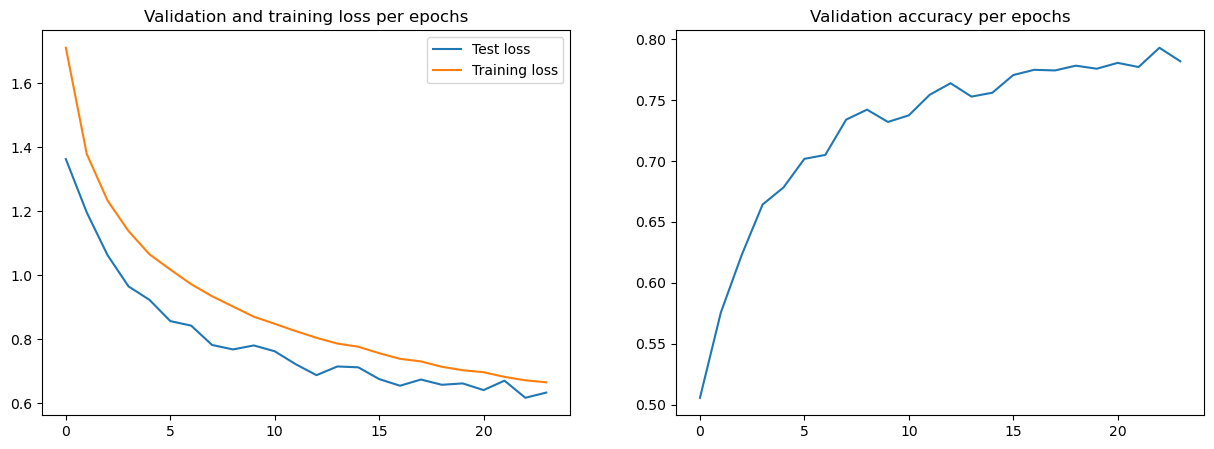

In [ ]:
# Model 3 performance visualisation

no_of_epoch = list(range(len(model_CNN_final_val_loss_aug)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Validation and training loss per epochs")
plt.plot(no_of_epoch, model_CNN_final_val_loss_aug, label='Test loss')
plt.plot(no_of_epoch, model_CNN_final_training_loss_aug, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Validation accuracy per epochs")
plt.plot(no_of_epoch, model_CNN_final_val_accuracy_aug)

In [ ]:
# Model 3s' saved performance on validation set:

print(f"Third models' saved performance accuracy on test set is: {model_CNN_final_val_accuracy_aug[-8]*100:.2f}%.")

Third models' saved performance accuracy on test set is: 77.49%.


The final proposed model is the third model trained with data augmentation. When retrained with the whole training data, it achieves test accuracy of 77.49%, which is slightly better than its performance on the validation set.

## Pretrained CNN model

The performance  of simple models defined by this study is compared to the performance of EfficientNet in this section.

### Libraries

In [ ]:
from torchvision import models
from torchvision.transforms import v2

### Hyperparameters

The same hyperparameters are used as in the training of previous CNN models. Interpolation is applied to input images to test if a deeper model can benefit from increased spatial resolution.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
INPUT_SIZE = 32,32,3
TARGET_SIZE = 64, 64,3
VALIDATION_SPLIT = 0
LEARNING_RATE = 0.0005

### Transforms

In [ ]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.PILToTensor(),
    v2.Resize(TARGET_SIZE[:2],interpolation = v2.InterpolationMode.BICUBIC),
    v2.ToDtype(torch.float32, scale=True),
#    v2.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
    ])

In [ ]:
test_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(TARGET_SIZE[:2],interpolation = v2.InterpolationMode.BICUBIC),
#    v2.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
    ])

### Download the data

In [ ]:
train =  datasets.CIFAR10('./', train = True, download=True, transform = transforms)
test_ds = datasets.CIFAR10('./', train = False, download=True, transform = test_transforms)
classnames = train.classes

Files already downloaded and verified
Files already downloaded and verified


### Training\validation split

Validation size was set to 0 as no hyperparameter tuning is considered for this model. However, the code is still provide in the case of change in the methodology at some future point.

In [ ]:
num_classes = len(train)
train_ds, val_ds = random_split(train,[1-VALIDATION_SPLIT ,VALIDATION_SPLIT])
print(f'train_ds size {len(train_ds)}, val_ds size: {len(val_ds)}, test_ds size: {len(test_ds)}')

train_ds size 50000, val_ds size: 0, test_ds size: 10000


c:\Users\Sven\anaconda3\envs\CS_985\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


### DataLoader

In [ ]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, BATCH_SIZE, num_workers=2, pin_memory=True)

# val_loader = DataLoader(val_ds, BATCH_SIZE, num_workers=2, pin_memory=True)

### Load the model

EfficientNet model is provided in PyTorch torchvision library and is not required to be manually defined.

In [ ]:
effnet_model = models.efficientnet_b0(models.EfficientNet_B0_Weights)
effnet_model_untrained = models.efficientnet_b0()

effnet_model.to(device)

c:\Users\Sven\anaconda3\envs\CS_985\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Sven\anaconda3\envs\CS_985\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Training function

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet_model.parameters(), lr=LEARNING_RATE)

def train_updated(num_epochs, model, data_loaded, validation_loaded, checkpoint_path, loss_func, optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0):
    model.train()

    for epoch in range(num_epochs):

        loss_acc = 0 # For tracking the loss at each epoch
        n = len(data_loaded)

        for i, (images, labels) in enumerate(data_loaded):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            loss_acc += loss

        loss_acc = loss_acc/n  # Lost over the whole training data
        training_loss.append(loss_acc.item())

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss_acc))


        # val_accuracy_, valid_loss_ = model_validation(validation_loaded, model, loss_func)

        # print(f"Validation accuracy: {val_accuracy_*100:.2f}%.")
        # print(f"Validation loss: {valid_loss_:.4f}.")


        # --- validate
        num_correct = 0
        num_samples = 0
        val_loss = 0.0

        model.eval()
        for data, target in validation_loaded:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_func(output, target) # calculate the batch loss
            correct = torch.eq(torch.max(torch.nn.functional.softmax(output), dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_samples += correct.shape[0]
            val_loss += loss.item()*data.size(0) # update average validation loss

        val_loss_ = val_loss/len(validation_loaded.dataset)
        val_accuracy_ = num_correct / num_samples
        val_accuracy.append(val_accuracy_)
        valid_loss.append(val_loss_)

        print(f"Validation accuracy: {val_accuracy_ *100:.2f}%.")

        if epoch == 0:
            best_loss = val_loss_
            torch.save(model, checkpoint_path)
            print("\n")
        else:
            counter, best_loss = EarlyStop(val_loss_, best_loss, counter, model, checkpoint_path)
            print(f"The number of epochs without improvement: {counter}.\n")

        if counter == tolerance:
            print(f"The training stopped after {epoch} epochs.")
            return valid_loss, val_accuracy, training_loss

    return valid_loss, val_accuracy, training_loss

### Model Training

As not parameter changes are considered, the model is immediately validated on test data.

In [ ]:
path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1.pth"
CNN_test_loss, CNN_test_accuracy, CNN_training_loss = train_updated(num_epochs = EPOCHS, model = effnet_model, data_loaded = train_loader, validation_loaded = test_loader, checkpoint_path = path, loss_func = loss_fn, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0)

Epoch [1/100], Loss: 1.1887


C:\Users\Sven\AppData\Local\Temp\ipykernel_23520\623875270.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(torch.nn.functional.softmax(output), dim=1)[1], target).view(-1)


Test accuracy: 85.22%.


Epoch [2/100], Loss: 0.4746
Test accuracy: 81.49%.
The number of epochs without improvement: 1.

Epoch [3/100], Loss: 0.3418
Test accuracy: 85.41%.
The number of epochs without improvement: 2.

Epoch [4/100], Loss: 0.2972
Test accuracy: 89.05%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 0.2603
Test accuracy: 88.67%.
The number of epochs without improvement: 1.

Epoch [6/100], Loss: 0.2385
Test accuracy: 90.32%.
The number of epochs without improvement: 0.

Epoch [7/100], Loss: 0.2060
Test accuracy: 90.03%.
The number of epochs without improvement: 1.

Epoch [8/100], Loss: 0.1916
Test accuracy: 90.78%.
The number of epochs without improvement: 2.

Epoch [9/100], Loss: 0.1807
Test accuracy: 89.45%.
The number of epochs without improvement: 3.

Epoch [10/100], Loss: 0.1657
Test accuracy: 90.29%.
The number of epochs without improvement: 4.

Epoch [11/100], Loss: 0.1575
Test accuracy: 90.83%.
The number of epochs without improvement: 5.

Epo

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_valid_loss.cvs"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(CNN_test_loss)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(CNN_test_accuracy)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(CNN_training_loss)

In [ ]:
# Load the performance from a csv file

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_valid_loss.cvs"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    CNN_test_loss = next(reader)
    CNN_test_loss = [float(x) for x in CNN_test_loss]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    CNN_test_accuracy = next(reader)
    CNN_test_accuracy = [float(x) for x in CNN_test_accuracy]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    CNN_training_loss = next(reader)
    CNN_training_loss= [float(x) for x in CNN_training_loss]

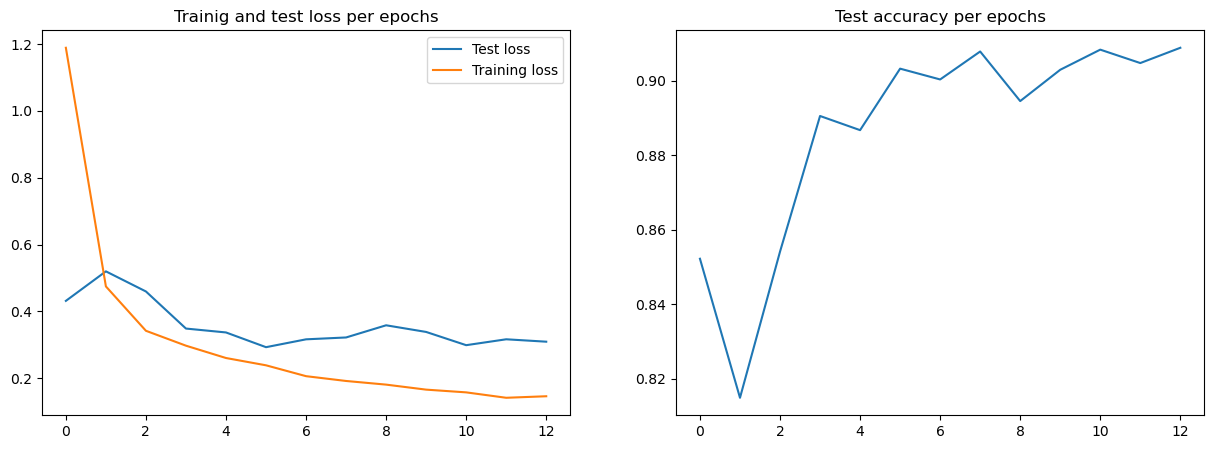

In [ ]:
# Model  performance visualisation

no_of_epoch = list(range(len(CNN_test_loss)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Trainig and test loss per epochs")
plt.plot(no_of_epoch, CNN_test_loss, label='Test loss')
plt.plot(no_of_epoch, CNN_training_loss, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Test accuracy per epochs")
plt.plot(no_of_epoch, CNN_test_accuracy)

In [ ]:
# Models' saved performance on validation set:

print(f"Third models' saved performance accuracy on test set is: {CNN_test_accuracy[-8]*100:.2f}%.")

Third models' saved performance accuracy on test set is: 90.32%.


The model outperforms this studies' best model by over 10%, whill taking roughly the same time te be trained.

### Model evaluation

Next, the models' performance is broken down for each of the ten classes.

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model_to_ev = torch.load("C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_CNN\\train_1.pth")
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_to_ev.eval()

# iterate over test data
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()

    output = model_to_ev(data) # model predictions
    loss = loss_fn(output, target) # batch loss
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1) # Collapse prob to class

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classnames[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classnames[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\Users\Sven\AppData\Local\Temp\ipykernel_81244\4237945109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_to_ev = torch.load("C:\\Users\\Sven\\Desktop\\CS_985_pr

Test Loss: 0.292758

Test Accuracy of airplane: 92% (922/1000)
Test Accuracy of automobile: 95% (958/1000)
Test Accuracy of  bird: 85% (858/1000)
Test Accuracy of   cat: 85% (855/1000)
Test Accuracy of  deer: 92% (921/1000)
Test Accuracy of   dog: 75% (755/1000)
Test Accuracy of  frog: 96% (969/1000)
Test Accuracy of horse: 93% (938/1000)
Test Accuracy of  ship: 94% (946/1000)
Test Accuracy of truck: 91% (910/1000)

Test Accuracy (Overall): 90% (9032/10000)


Looking at the models' performance per class, it is noted that the model performs worse when classifying animals, compared to classifying vehicles. This can perhaps be attributed to animals in CIFAR-10 data set having many of the similar features which can lead to wrong classification.

# Part 2: ViT

## Hyperparameters

The same parameters are used as in the previous trainings.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
INPUT_SIZE = 32,32,3
# TARGET_SIZE = 64, 64,3
VALIDATION_SPLIT = 0
LEARNING_RATE = 0.0005

## Define tarnsforms

In [ ]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
#    v2.RandomRotation(20),
    v2.PILToTensor(),
#    v2.Resize(TARGET_SIZE[:2],interpolation = v2.InterpolationMode.BICUBIC),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))])

In [ ]:
test_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
#    v2.Resize(TARGET_SIZE[:2],interpolation = v2.InterpolationMode.BICUBIC),
    v2.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))])

### Download the data

In [ ]:
train =  datasets.CIFAR10('./', train = True, download=True, transform = transforms)
test_ds = datasets.CIFAR10('./', train = False, download=True, transform = test_transforms)
classnames = train.classes

Files already downloaded and verified
Files already downloaded and verified


### Training\validation split

In [ ]:
num_classes = len(train)
train_ds, val_ds = random_split(train,[1-VALIDATION_SPLIT ,VALIDATION_SPLIT])
print(f'train_ds size {len(train_ds)}, val_ds size: {len(val_ds)}, test_ds size: {len(test_ds)}')

train_ds size 50000, val_ds size: 0, test_ds size: 10000


### DataLoader

In [ ]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, BATCH_SIZE, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, BATCH_SIZE, num_workers=2, pin_memory=True)

### Visualise one batch

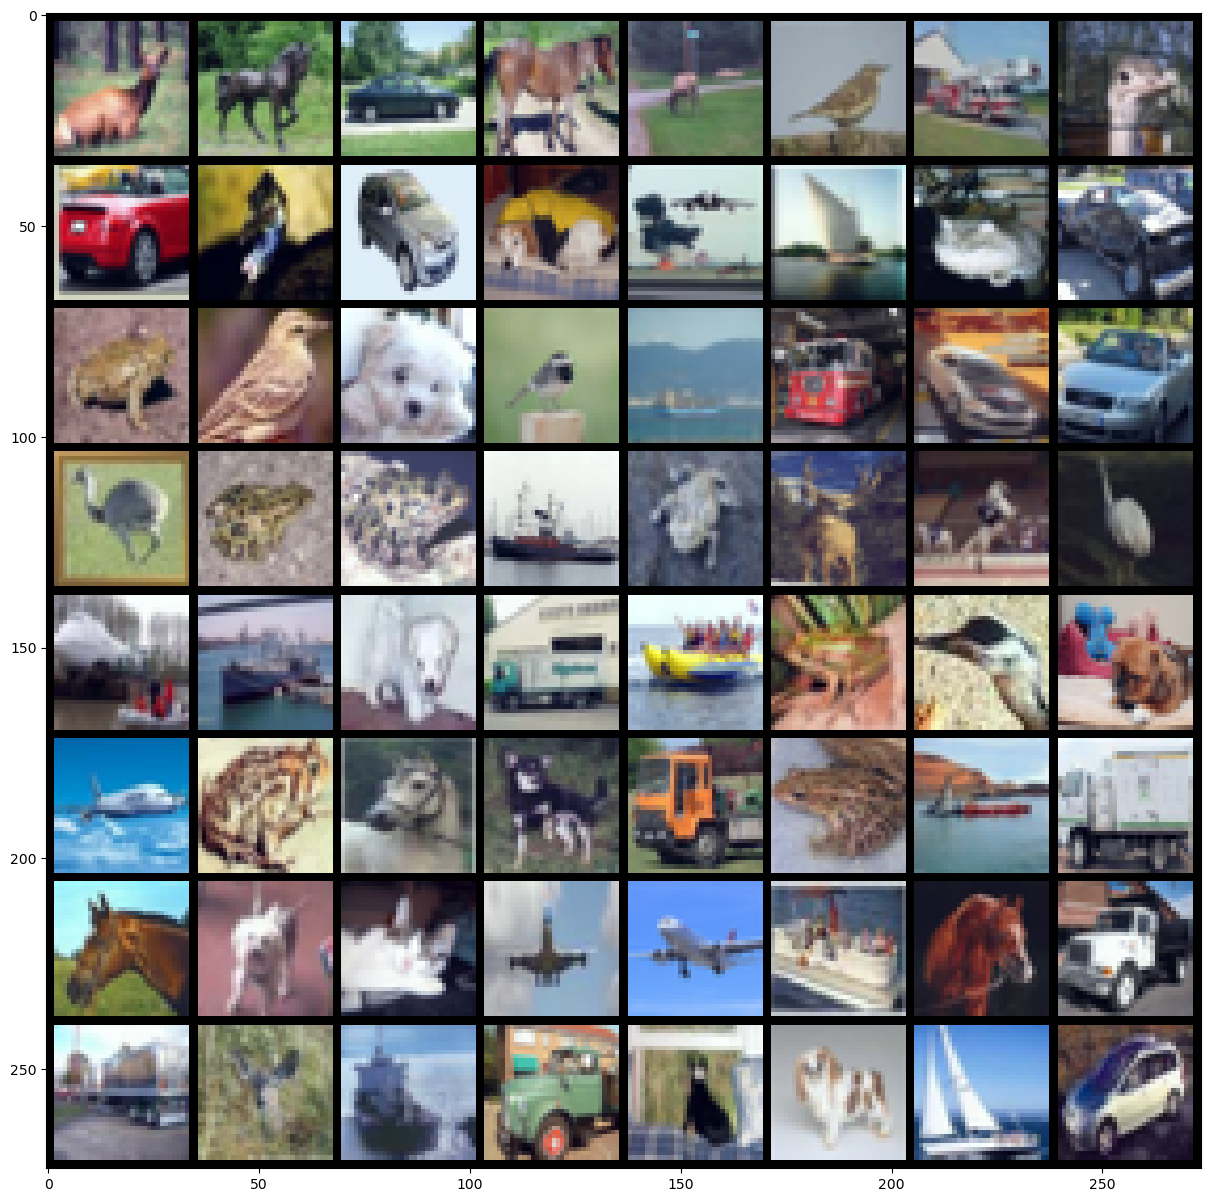

In [ ]:
data_batch = next(iter(train_loader))
train_im_batch, train_label_batch = data_batch

plt.figure(figsize=(15, 15))
grid_out = torchvision.utils.make_grid(train_im_batch, 8, normalize = True)
plt.imshow(grid_out.numpy().transpose((1, 2, 0)))

## __Note__:

The following three sections were inspired by the following GitHub repo: https://github.com/LukeDitria/pytorch_tutorials/blob/main/section14_transformers/solutions/Pytorch4_Vision_Transformers.ipynb,
and the whole credit goes to the author.

### Function for extracting patches

ViT divides images input smaller patches which are then flattened and fed into a Transformer. Image division into patches is performed by the function defined below.

In [ ]:
patch_size = 4

def im_patches(im_tensor, patch_size = patch_size):
    batch_size, channel_size = im_tensor.size()[:2] # Dimensions of the input tensor

    unfold = nn.Unfold(kernel_size = (patch_size, patch_size), stride = patch_size) # Define unfold layer

    unfolded = unfold(im_tensor) # Apply unfold to an image

    unfolded = unfolded.transpose(1, 2).reshape(batch_size, -1, channel_size * patch_size * patch_size) # Reshape the unfolded tensor

    return unfolded

### Visualisation of patch extraction

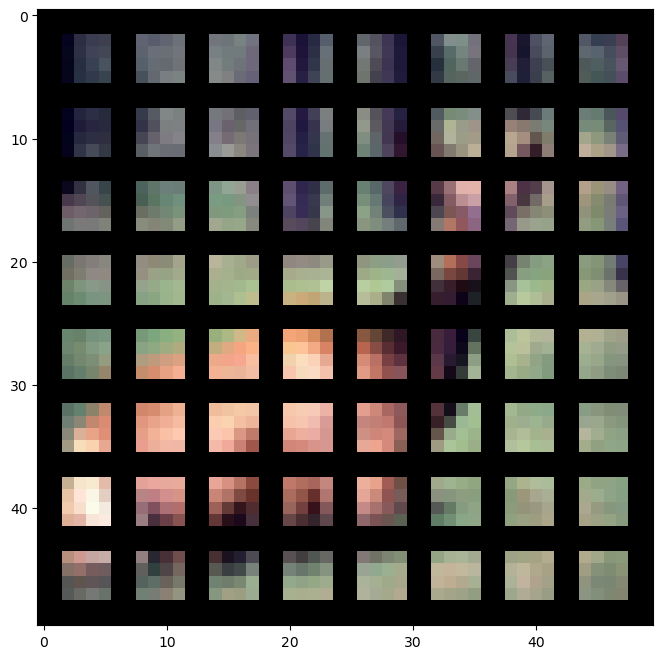

In [ ]:
patch_size = 4
# Extract patches
im_patched = im_patches(train_im_batch, patch_size=patch_size)

# Reshape patches
im_square = im_patched.reshape(train_im_batch.shape[0], -1, 3, patch_size, patch_size)

# Grid size
grid_size = train_im_batch.shape[2] // patch_size

# Visualisation
plt.figure(figsize=(8, 8))
grid_out = torchvision.utils.make_grid(im_square[0], 8, normalize = True)
plt.imshow(grid_out.numpy().transpose((1, 2, 0)))

### ViT architecture

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()

        # Layer normalization to normalize the input data
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads,
                                                    batch_first=True, dropout=0.1)

        # Another layer normalization
        self.norm2 = nn.LayerNorm(hidden_size)

        # Multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )

    def forward(self, x):
        # Apply the first layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head attention and add the input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

        # Apply the second layer normalization
        norm_x = self.norm2(x)

        # Pass through the MLP and add the input (residual connection)
        x = self.mlp(norm_x) + x

        return x


class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):
        # Call the __init__ function of the parent nn.Module class
        super().__init__()

        self.patch_size = patch_size

        # Fully connected layer to project input patches to the hidden size dimension
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)

        # Create a list of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Fully connected output layer to map to the number of classes (e.g., 10 for CIFAR-10)
        self.fc_out = nn.Linear(hidden_size, 10)

        # Parameter for the output token
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        # Positional embeddings to retain positional information of patches
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))

    def forward(self, image):
        bs = image.shape[0]

        # Extract patches from the image and flatten them
        patch_seq = im_patches(image, patch_size=self.patch_size)

        # Project patches to the hidden size dimension
        patch_emb = self.fc_in(patch_seq)

        # Add positional embeddings to the patch embeddings
        patch_emb = patch_emb + self.pos_embedding

        # Concatenate the output token to the patch embeddings
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        # Pass the embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs)

        # Use the embedding of the output token for classification
        return self.fc_out(embs[:, 0])

### Model training

In [ ]:
model_vit = ViT(image_size= train_im_batch.shape[2], channels_in= train_im_batch.shape[1], patch_size=patch_size, hidden_size = 128, num_layers = 10, num_heads = 8).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vit.parameters(), lr=LEARNING_RATE)

path = "C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1.pth"
vit_valid_loss, vit_valid_accuracy, vit_training_loss = train_updated(num_epochs = EPOCHS, model = model_vit, data_loaded = train_loader, validation_loaded = test_loader, checkpoint_path = path, loss_func = loss_fn, optimizer = optimizer, valid_loss = [], val_accuracy = [], training_loss =[], tolerance = 7, counter = 0)

Epoch [1/100], Loss: 1.6490


C:\Users\Sven\AppData\Local\Temp\ipykernel_81244\3387717462.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(torch.nn.functional.softmax(output), dim=1)[1], target).view(-1)


Validation accuracy: 49.61%.


Epoch [2/100], Loss: 1.2664
Validation accuracy: 54.04%.
The number of epochs without improvement: 0.

Epoch [3/100], Loss: 1.1302
Validation accuracy: 59.68%.
The number of epochs without improvement: 0.

Epoch [4/100], Loss: 1.0454
Validation accuracy: 60.97%.
The number of epochs without improvement: 0.

Epoch [5/100], Loss: 0.9815
Validation accuracy: 63.54%.
The number of epochs without improvement: 0.

Epoch [6/100], Loss: 0.9264
Validation accuracy: 64.84%.
The number of epochs without improvement: 1.

Epoch [7/100], Loss: 0.8833
Validation accuracy: 63.62%.
The number of epochs without improvement: 2.

Epoch [8/100], Loss: 0.8421
Validation accuracy: 66.74%.
The number of epochs without improvement: 0.

Epoch [9/100], Loss: 0.8037
Validation accuracy: 66.72%.
The number of epochs without improvement: 1.

Epoch [10/100], Loss: 0.7658
Validation accuracy: 67.95%.
The number of epochs without improvement: 2.

Epoch [11/100], Loss: 0.7307
Validation a

In [ ]:
# Save the performance per epoch

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_valid_loss.cvs"
os.makedirs(os.path.dirname(path_val_loss), exist_ok = True)

with open(path_val_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(vit_valid_loss)


path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_val_accuracy.csv"
os.makedirs(os.path.dirname(path_val_accuracy), exist_ok = True)

with open(path_val_accuracy, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(vit_valid_accuracy)

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_training_loss.csv"
os.makedirs(os.path.dirname(path_training_loss), exist_ok = True)

with open(path_training_loss, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(vit_training_loss)

In [ ]:
# Load the performance from a csv file

path_val_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_valid_loss.cvs"

with open(path_val_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    vit_valid_loss = next(reader)
    vit_valid_loss = [float(x) for x in vit_valid_loss]

path_val_accuracy ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_val_accuracy.csv"

with open(path_val_accuracy) as fp:
    reader = csv.reader(fp, delimiter=",")
    vit_valid_accuracy = next(reader)
    vit_valid_accuracy = [float(x) for x in vit_valid_accuracy]

path_training_loss ="C:\\Users\\Sven\\Desktop\\CS_985_project\\Weights\\model_vit\\train_1_training_loss.csv"

with open(path_training_loss) as fp:
    reader = csv.reader(fp, delimiter=",")
    vit_training_loss = next(reader)
    vit_training_loss= [float(x) for x in vit_training_loss]

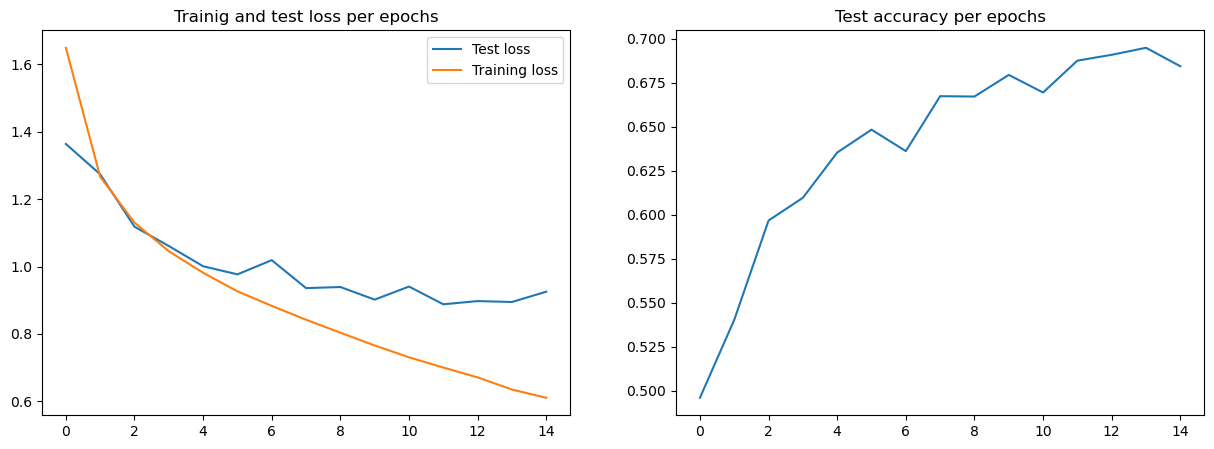

In [ ]:
# Model  performance visualisation

no_of_epoch = list(range(len(vit_valid_loss)))

figure = plt.figure(figsize=(15, 5))

figure.add_subplot(1, 2, 1)
plt.title("Trainig and test loss per epochs")
plt.plot(no_of_epoch, vit_valid_loss, label='Test loss')
plt.plot(no_of_epoch, vit_training_loss, label='Training loss')
plt.legend()

figure.add_subplot(1, 2, 2)
plt.title("Test accuracy per epochs")
plt.plot(no_of_epoch, vit_valid_accuracy)

In [ ]:
# Models' saved performance on test set:

print(f"Third models' saved performance accuracy on test set is: {vit_valid_accuracy[-8]*100:.2f}%.")

Third models' saved performance accuracy on test set is: 66.74%.


The performance of the built ViT model for its best epoch is 66.74%.

## Conclusion

This report has built multiple models for classification of CIFAR-10 data set. Two different types of models were considered: Convolutional Neural Network (CNN) and Vision Transformer (ViT).

Three costume CNNs were built and trained under various conditions, which included using interpolation of input images and augmentation. It was found that applying augmentation with some random probability has significantly improved the performance of all models while simultaneously preventing models from overfitting to the training data. Interpolation of input images has significantly increased the training time, but without the increase in performance. On contrary, all models performed worse. However, the performance decreased a lot more for the smaller two models compared to the biggest defined CNN. This indicates that deeper models could perhaps still utilise the interpolated inputs. To test this, a significantly larger EfiicientNet CNN was trained on interpolated data. It had significantly outperformed all the other models. 

To compare different frameworks, a ViT model was built. ViTs, unlike CNNs consider images globally, instead of locally. The trained ViT models' performance was comparable to the first and second built (smaller) CNN models. However, it performed significantly worse compared to the third defined (deeper) CNN model and larger EfficientNet model.

The two simple CNN models were trained in under few minutes for all different training runs. The remaining three models (third CNN, EfficientNet and Vit) roughly took around 10 minutes to train and their training time per epoch did not significantly differ. 

The future studies should train ViT under different initial conditions, which is something that was not conducted in this study due to time constraint. Training ViT with different frameworks could improve its performance and make it more competative.

## Reference list

[1] LeCun, Y., Boser, B., Denker, J.S., Henderson, D., Howard, R.E., Hubbard, W. and Jackel, L.D., 1989. Backpropagation applied to handwritten zip code recognition. Neural computation, 1(4), pp.541-551.

[2] Krizhevsky, A., Sutskever, I. and Hinton, G.E., 2012. Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.

[3] Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M. and Berg, A.C., 2015. Imagenet large scale visual recognition challenge. International journal of computer vision, 115, pp.211-252.

[4] Simonyan, K., & Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition (No. arXiv:1409.1556). arXiv. https://doi.org/10.48550/arXiv.1409.1556

[5] He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition (No. arXiv:1512.03385). arXiv. https://doi.org/10.48550/arXiv.1512.03385

[6] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (No. arXiv:2010.11929). arXiv. https://doi.org/10.48550/arXiv.2010.11929

[7] Tan, M., & Le, Q. V. (2020). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (No. arXiv:1905.11946). arXiv. https://doi.org/10.48550/arXiv.1905.11946





